# Lec 31: Variational Autoencoders II and GANs I

## Instructions
Build a Convolutional VAE for the EuroSAT dataset

1. Demonstrate by plotting original and reconstructed images that your model is performing well. You are free to choose your model configuration and any hyperparameters
2. Plot the reconstructed images from the mean of latent representations for 'Industrial'  and 'Forest' classes
3. Plot the transition from 'Industrial' to 'Forest' by moving in the latent space from one class to another in 10 steps and generating the full images using the decoder

## Imports

In [1]:
import json
import matplotlib.pyplot as plt

In [2]:
# PyTorch imports
import torch
import torch.nn as nn

In [3]:
# Import helper files
from helpers.helper_utils import set_all_seeds
from helpers.helper_data import get_dataloaders_eurosat, compute_average_class
from helpers.helper_models import Reshape, Trim
from helpers.helper_train import train_cvae
from helpers.helper_plots import plot_generated_images, plot_modified_classes

## Settings

In [4]:
# Hyperparameters
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 100

# Other settings
DEVICE = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 123
SAVED_DATA_PATH = '/Users/nxvgalang/Documents/main/college/cs6073/uc-cs6073-deep-learning/lec31/saved_data/'

set_all_seeds(RANDOM_SEED)
print(f'Device: {DEVICE}')

Device: cpu


In [ ]:
# If running on Colab, uncomment this code

# from google.colab import drive
# drive.mount('/content/drive')

# SAVED_DATA_PATH = 'drive/MyDrive/saved_data/'

## EuroSAT Dataset

In [5]:
train_loader = get_dataloaders_eurosat(BATCH_SIZE, num_workers=8)

# Verify dataset
print('Train Dataset:')
for images, labels in train_loader:
    print(f'Image batch dimensions: {images.size()}')
    print(f'Image label dimensions: {labels.size()}')
    break

Train Dataset:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])


## Convolutional Variational Autoencoder Model

Convolutional layer output size formula:
$$o=\lfloor\frac{i+2p-k}{s}\rfloor+1$$

Transposed convolutional layer output size formula:
$$o=s(i-1)+k-2p$$

In [6]:
class CVAE(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # 3 channels x 64x64 pixel images

            # Output: 32 channels x 32x32 pixel images
            nn.Conv2d(3, 32, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            
            # Output: 64 channels x 16x16 pixel images
            nn.Conv2d(32, 64, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            # Output: 128 channels x 8x8 pixel images
            nn.Conv2d(64, 128, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),

            # Output: 256 channels x 4x4 pixel images
            nn.Conv2d(128, 256, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),

            # Output: 256x4x4 = 4096 features
            nn.Flatten()
        )

        # Fully connected layer: 4096 -> 512
        self.z_mean = nn.Linear(4096, 512)

        # Fully connected layer: 4096 -> 512
        self.z_log_var = nn.Linear(4096, 512)

        self.decoder = nn.Sequential(
            # Fully connected layer: 512 -> 4096
            nn.Linear(512, 4096),

            # Reshape to 256x4x4 (how it was in encoder before flattening)
            Reshape(-1, 256, 4, 4),

            # Output: 128 channels x 9x9 pixel images
            nn.ConvTranspose2d(256, 128, stride=2, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),

            # Output: 64 channels, 17x17 pixel images
            nn.ConvTranspose2d(128, 64, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            # Output: 32 channels, 33x33 pixel images
            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),

            # Output: 3 channels, 65x65 pixel images
            nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),

            # Trim images from 65x65 to 64x64
            Trim(64),
            nn.Sigmoid()
        )
    
    def encoding_fn(self, x):
        x = self.encoder(x)

        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)

        encoded = self.reparameterize(z_mean, z_log_var)

        return encoded

    def reparameterize(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.size(0), z_mean.size(1)).to(DEVICE)
        z = z_mean + eps * torch.exp(z_log_var / 2.)
        return z

    def forward(self, x):
        x = self.encoder(x)

        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)

        decoded = self.decoder(encoded)

        return encoded, z_mean, z_log_var, decoded

In [ ]:
model = CVAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [ ]:
log_dict = train_cvae(
    model,
    optimizer,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    device=DEVICE
)

In [ ]:
torch.save(model.state_dict(), SAVED_DATA_PATH + 'model.pt')
with open(SAVED_DATA_PATH + 'logs.json', 'w') as f:
    json.dump(log_dict, f)

## Load Model

In [7]:
SAVED_DATA_PATH = '/Users/nxvgalang/Documents/main/college/cs6073/uc-cs6073-deep-learning/lec31/saved_data/'

model = CVAE()
model.load_state_dict(torch.load(SAVED_DATA_PATH + 'model.pt', map_location=DEVICE), )

<All keys matched successfully>

## Plotting

### Plot Reconstructed Images

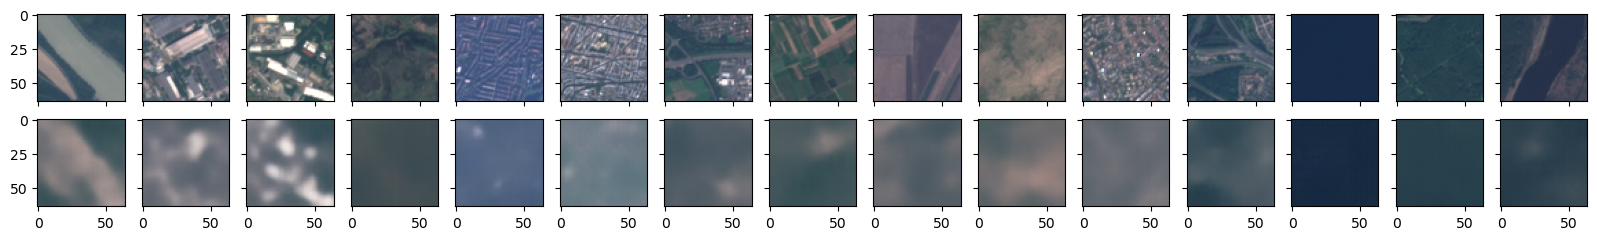

In [8]:
plot_generated_images(
    model,
    data_loader=train_loader,
    device=DEVICE,
    
)

### Plot Average "Forest" Class in Latent Space

In [9]:
avg_img_with_forest, avg_img_without_forest = compute_average_class(
    class_idx=1,
    image_dim=512,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn
)

In [10]:
with torch.no_grad():
    avg_img_with_forest.to(DEVICE)
    avg_forest = model.decoder(avg_img_with_forest).to(torch.device('cpu')).squeeze(0)

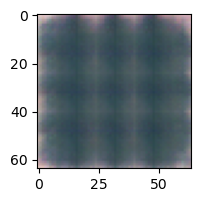

In [11]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_forest).permute(1, 2, 0))
plt.show()

### Plot Average "Industrial" Class in Latent Space

In [12]:
avg_img_with_industrial, avg_img_without_industrial = compute_average_class(
    class_idx=4,
    image_dim=512,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn
)

In [13]:
with torch.no_grad():
    avg_img_with_industrial.to(DEVICE)
    avg_industrial = model.decoder(avg_img_with_industrial).to(torch.device('cpu')).squeeze(0)

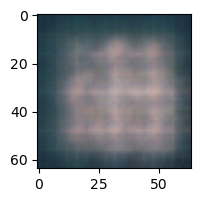

In [14]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_industrial).permute(1, 2, 0))
plt.show()

### Plot 10-step Transition from "Industrial" to "Forest" Class

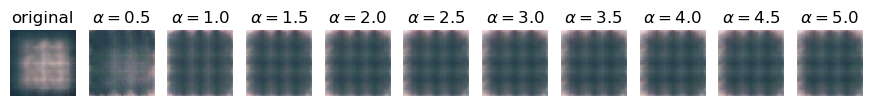

In [15]:
diff = avg_img_with_forest - avg_img_with_industrial

plot_modified_classes(
    original=avg_img_with_industrial,
    diff=diff,
    decoding_fn=model.decoder,
    device=DEVICE
)
plt.show()